This is following the example code for GAN in the Dive Into Deep Learning online course here: https://d2l.ai/chapter_generative-adversarial-networks/gan.html#generate-some-real-data 

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
X = torch.normal(0.0, 1, (1000, 2))
A = torch.tensor([[1, 2], [-0.1, 0.5]])
b = torch.tensor([1, 2])
data = torch.matmul(X, A) + b

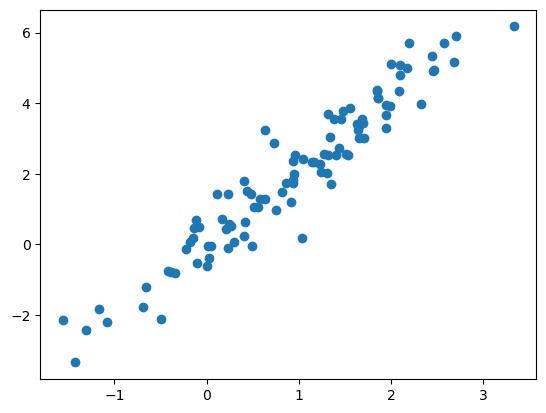

In [3]:
plt.scatter(data[:100, 0].detach().numpy(), data[:100, 1].detach().numpy())
plt.show()

In [4]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(data)

batch_size = 8
data_iter = DataLoader(dataset, batch_size=batch_size)

In [5]:
net_G = nn.Sequential(nn.Linear(2, 2))
net_D = nn.Sequential(
    nn.Linear(2, 5), nn.Tanh(),
    nn.Linear(5, 3), nn.Tanh(),
    nn.Linear(3, 1)
)

In [6]:
def update_D(X, Z, net_D, net_G, loss, trainer_D):
    batch_size = X.shape[0]
    ones = torch.ones((batch_size,), device=X.device)
    zeros = torch.zeros((batch_size,), device=X.device)
    trainer_D.zero_grad()
    real_Y = net_D(X)
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X.detach())
    loss_D = (loss(real_Y, ones.reshape(real_Y.shape)) + loss(fake_Y, zeros.reshape(fake_Y.shape))) / 2
    loss_D.backward()
    trainer_D.step()
    return loss_D

In [7]:
def update_G(Z, net_D, net_G, loss, trainer_G):
    batch_size = Z.shape[0]
    ones = torch.ones((batch_size,), device=Z.device)
    trainer_G.zero_grad()
    fake_X = net_G(Z)
    fake_Y = net_D(fake_X)
    loss_G = loss(fake_Y, ones.reshape(fake_Y.shape))
    loss_G.backward()
    trainer_G.step()
    return loss_G

In [8]:
def train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    trainer_D = torch.optim.Adam(net_D.parameters(), lr=lr_D)
    trainer_G = torch.optim.Adam(net_G.parameters(), lr=lr_G)
    fake_X_history = []
    total_loss_D_history, total_loss_G_history = [], []
    
    for epoch in range(num_epochs):
        total_loss_D, total_loss_G, total_cnt = 0, 0, 0
        for (X,) in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim))
            loss_D = update_D(X, Z, net_D, net_G, loss, trainer_D)
            loss_G = update_G(Z, net_D, net_G, loss, trainer_G)
            total_loss_D += loss_D.item()
            total_loss_G += loss_G.item()
            total_cnt += batch_size

        Z = torch.normal(0, 1, size=(100, latent_dim))
        fake_X = net_G(Z).detach().numpy()
        fake_X_history.append(fake_X)
        total_loss_D_history.append(loss_D.item() / batch_size)
        total_loss_G_history.append(loss_G.item() / batch_size)

    line_D, = plt.plot(range(num_epochs), total_loss_D_history, label='loss D')
    line_G, = plt.plot(range(num_epochs), total_loss_G_history, label='loss G')
    plt.legend(handles=[line_D, line_G], labels=['loss D', 'loss G'])
    plt.show()
    plt.close()

    fig, ax = plt.subplots()
    xmin, xmax = min(data[:, 0]), max(data[:, 0])
    ymin, ymax = min(data[:, 1]), max(data[:, 1])
    def _update(frame):
        ax.clear()
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.scatter(data[:, 0], data[:, 1])
        ax.scatter(fake_X_history[frame][:, 0], fake_X_history[frame][:, 1])

    return animation.FuncAnimation(fig, _update, frames=len(fake_X_history), interval=200, repeat=False)
    

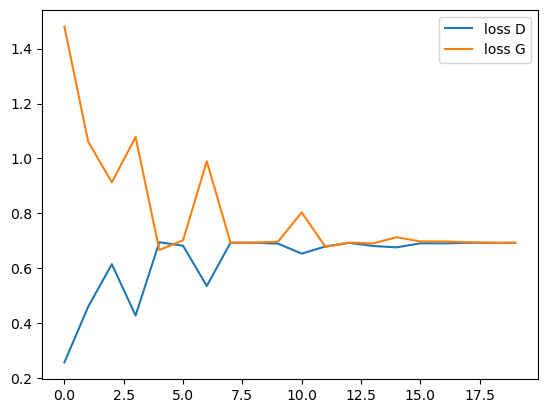

In [9]:
lr_D, lr_G, latent_dim, num_epochs = 0.05, 0.005, 2, 20
ani = train(net_D, net_G, data_iter, num_epochs, lr_D, lr_G, latent_dim, data[:100].detach().numpy())
plt.close()
HTML(ani.to_jshtml())